# DataLoader

In [1]:
import tensorflow as tf
tf.__version__

tf.random.set_seed(1202)

2024-01-25 04:07:13.747186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 04:07:13.854563: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 04:07:14.435739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-25 04:07:14.435793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
AMAZON = "amazon"
DSLR = "dslr"
WEBCAM = "webcam"

DIR_RESULT = "result_latent/"

DIR_AMAZON = "office31/{}".format(AMAZON)
DIR_DSLR = "office31/{}".format(DSLR)
DIR_WEBCAM = "office31/{}".format(WEBCAM)

################################## config #################################

# 0, 1, 2, 3, 4
M, N, O = 1, 2, 2

DIR_SOURCE = DIR_DSLR
DIR_TARGET = DIR_WEBCAM

###########################################################################

if DIR_SOURCE == DIR_AMAZON:
    SOURCE = AMAZON
elif DIR_SOURCE == DIR_DSLR:
    SOURCE = DSLR
elif DIR_SOURCE == DIR_WEBCAM:
    SOURCE = WEBCAM
    
if DIR_TARGET == DIR_AMAZON:
    SOURCE = AMAZON
elif DIR_TARGET == DIR_DSLR:
    SOURCE = DSLR
elif DIR_TARGET == DIR_WEBCAM:
    SOURCE = WEBCAM

BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DIM = 3

LATENT_DIM = 64

EPOCHS = 100

scales = [0, 0.1, 0.3, 0.6, 0.01]

W_CATEGORICAL = scales[M]
W_ADVERSARIAL = scales[N]
W_DOMAIN      = scales[O]
    
TITLE = "{}_{} = {}-{}-{}".format(AMAZON, WEBCAM, W_CATEGORICAL, W_ADVERSARIAL, W_DOMAIN)
    

In [3]:
TITLE

'amazon_webcam = 0.1-0.3-0.3'

In [4]:

class DataLoader:

    def __init__(self, source, target, BATCH_SIZE=64, IMG_HEIGHT = 128, IMG_WIDTH = 128, IMG_DIM = 3):
        self.source = source
        self.target = target
        self.BATCH_SIZE = BATCH_SIZE
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_DIM = IMG_DIM
        self.normalization_layer = tf.keras.layers.Rescaling(1./255)

    def load_source_train(self):
        dataset_source =  tf.keras.utils.image_dataset_from_directory(
                                self.source,
                                validation_split=0.2,
                                subset="training",
                                seed=123,
                                image_size=(self.IMG_HEIGHT, self.IMG_WIDTH),
                                batch_size=self.BATCH_SIZE)

        return dataset_source.map(lambda x, y: (self.normalization_layer(x), y))


    def load_source_validation(self):
        dataset_source_val =  tf.keras.utils.image_dataset_from_directory(
                                self.source,
                                validation_split=0.2,
                                subset="validation",
                                seed=123,
                                image_size=(self.IMG_HEIGHT, self.IMG_WIDTH),
                                batch_size=self.BATCH_SIZE)

        return dataset_source_val.map(lambda x, y: (self.normalization_layer(x), y))

    def load_target_test(self):
        dataset_target =  tf.keras.utils.image_dataset_from_directory(
                                self.target,
                                seed=123,
                                image_size=(self.IMG_HEIGHT, self.IMG_WIDTH),
                                batch_size=self.BATCH_SIZE)

        return dataset_target.map(lambda x, y: (self.normalization_layer(x), y))

    def load(self):
        return tf.data.Dataset.zip((self.load_source_train(), self.load_source_validation(), self.load_target_test()))


# Model

In [5]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

In [6]:

from tensorflow import keras
from tensorflow.keras import layers


class AML(tf.keras.Model):
    """Adeversarial Multitask Learning."""

    def __init__(self, weight_adversarial=0, weight_categorical=0, weight_domain=0):
        super(AML, self).__init__()

        self.InceptionV3 = tf.keras.applications.InceptionV3(
                            weights='imagenet',
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DIM),
                            include_top=False)

        self.InceptionV3.trainable = False
        
        self.domain_adapter = keras.Sequential(
            [
                layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
            ],
            name="domain_adapter",
        
        )

        self.feature_extractor = keras.Sequential(
                [
                    self.InceptionV3,
                    layers.GlobalAveragePooling2D(),
                    layers.Flatten(),
                    layers.Dropout(0.5),
                ],
                name="feature_extractor",
            )

        self.categorical_classifier = keras.Sequential(
                [
                    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
                    layers.Dropout(0.3),
                    layers.Dense(31, activation='softmax'),
                ],
                name="categorical_classifier",
            )

        self.domain_classifier = keras.Sequential(
            [
                layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
                layers.Dropout(0.3),
                GradReverse(),
                layers.Dense(1),
            ],
            name="domain_classifier",
        )

        self.generator = keras.Sequential(
            [
                keras.Input(shape=(LATENT_DIM,)),
                layers.Dense(64),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(256),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(2048),
                layers.LeakyReLU(alpha=0.2),
            ],
            name="generator",
        )

        self.discriminator = keras.Sequential(
            [
                layers.Dense(1),
            ],
            name="discriminator",
        )

        self.weight_categorical = weight_categorical
        self.weight_adversarial = weight_adversarial
        self.weight_domain      = weight_domain

        self.d_optimizer = keras.optimizers.Adam()
        self.g_optimizer = keras.optimizers.Adam()
        self.c_optimizer = keras.optimizers.Adam()
        self.fe_optimizer = keras.optimizers.Adam()
        self.domain_optimizer = keras.optimizers.Adam()

        self.val_accuracy = tf.keras.metrics.Accuracy()
        self.train_accuracy = tf.keras.metrics.Accuracy()
        self.target_accuracy = tf.keras.metrics.Accuracy()
        
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.loss_fn_cls = keras.losses.SparseCategoricalCrossentropy(from_logits=False)



    def sample(self):
        random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))
        data = self.generator(random_latent_vectors)
        features = self.domain_adapter(data)
        cat_cls = self.categorical_classifier(features)
        dom_cls = self.domain_classifier(features)
        dis_cls = self.discriminator(features)

        return cat_cls, dom_cls, dis_cls

    def predict_domain(self, x):
        features = self.feature_extractor(x)
        features = self.domain_adapter(features)
        return self.domain_classifier(features)

    def predict_category(self, x):
        features = self.feature_extractor(x)
        features = self.domain_adapter(features)
        return self.categorical_classifier(features)

    def predict_adversarial(self, x):
#         features = self.feature_extractor(x)
        features = self.domain_adapter(x)
        return self.discriminator(features)

    def generate_data(self):
        random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))
        return self.generator(random_latent_vectors)


In [7]:
model = AML(weight_adversarial=W_ADVERSARIAL, weight_categorical=W_CATEGORICAL, weight_domain=W_DOMAIN)
model.sample()

2024-01-25 04:07:15.340207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 04:07:15.953393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22822 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:37:00.0, compute capability: 7.5


(<tf.Tensor: shape=(64, 31), dtype=float32, numpy=
 array([[0.02730644, 0.02845862, 0.03920238, ..., 0.03158781, 0.0304055 ,
         0.03592204],
        [0.03290534, 0.02604862, 0.0412556 , ..., 0.03315455, 0.02736978,
         0.03479869],
        [0.03327323, 0.03164063, 0.04663121, ..., 0.03136528, 0.03033952,
         0.03301102],
        ...,
        [0.03617021, 0.02846538, 0.03817082, ..., 0.03527548, 0.03039392,
         0.03347931],
        [0.03826125, 0.0292316 , 0.04531699, ..., 0.03061724, 0.02773421,
         0.03429097],
        [0.03082054, 0.02976247, 0.05232373, ..., 0.03218718, 0.02854274,
         0.03200144]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1), dtype=float32, numpy=
 array([[-0.15937512],
        [-0.10791378],
        [-0.28893602],
        [-0.28455436],
        [-0.4191134 ],
        [-0.12518744],
        [-0.11879055],
        [-0.45869368],
        [-0.38746607],
        [-0.02991725],
        [-0.17319764],
        [-0.23556209],
        [-0.0344

In [8]:
model.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 256)               16640     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2048)              526336    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2048)              0         
                                                                 
Total params: 547,136
Trainable params: 547,136
Non-train

In [9]:
model.feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
@tf.function
def train_step(model, real_images, real_label, test_images, test_label, target_images, target_label):

    #adversarial data
    latent_generated_images = model.generate_data()
    latent_real_images = model.feature_extractor(real_images)
    
    combined_images = tf.concat([latent_generated_images, latent_real_images], axis=0)
    combined_labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
#     combined_labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((real_images.shape[0], 1))], axis=0)
    combined_labels += 0.05 * tf.random.uniform(combined_labels.shape)

    #domain
    combined_domain = tf.concat([target_images, real_images], axis=0)
    labels_domain = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
#     labels_domain = tf.concat([tf.ones((target_images.shape[0], 1)), tf.zeros((real_images.shape[0], 1))], axis=0)
    labels_domain += 0.05 * tf.random.uniform(labels_domain.shape)

    # Train the discriminator, cat_classifier, dom_classifier
    with tf.GradientTape(persistent=True) as tape:

        predictions_disc = model.predict_adversarial(combined_images)
        d_loss = model.loss_fn(combined_labels, predictions_disc)

        predictions_clas = model.predict_category(real_images)
        c_loss = model.loss_fn_cls(real_label, predictions_clas)

        predictions_domain = model.predict_domain(combined_domain)
        domain_loss = -1 * model.loss_fn(labels_domain, predictions_domain)
        # domain_loss = -1 * domain_loss

        fe_loss = model.weight_adversarial * d_loss + model.weight_categorical * c_loss + model.weight_domain * domain_loss

    grads_feature_extractor = tape.gradient(fe_loss, model.feature_extractor.trainable_weights)
    model.fe_optimizer.apply_gradients(zip(grads_feature_extractor, model.feature_extractor.trainable_weights))

    grads_discriminator = tape.gradient(d_loss, model.discriminator.trainable_weights)
    model.d_optimizer.apply_gradients(zip(grads_discriminator, model.discriminator.trainable_weights))

    grads_categorical = tape.gradient(c_loss, model.categorical_classifier.trainable_weights)
    model.c_optimizer.apply_gradients(zip(grads_categorical, model.categorical_classifier.trainable_weights))

    grads_domain = tape.gradient(domain_loss, model.domain_classifier.trainable_weights)
    model.domain_optimizer.apply_gradients(zip(grads_domain, model.domain_classifier.trainable_weights))

    # Train generator
    misleading_labels = tf.zeros((BATCH_SIZE, 1))
    with tf.GradientTape() as tape:
        generated_images = model.generate_data()
        predictions = model.predict_adversarial(generated_images)
        g_loss = model.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, model.generator.trainable_weights)
    model.g_optimizer.apply_gradients(zip(grads, model.generator.trainable_weights))

    c_acc_t = model.train_accuracy(tf.math.argmax(model.predict_category(real_images), 1) , real_label)
    c_acc_v = model.val_accuracy(tf.math.argmax(model.predict_category(test_images), 1), test_label)
    c_acc_target = model.target_accuracy(tf.math.argmax(model.predict_category(target_images), 1), target_label)

    return c_acc_target, c_acc_v, c_acc_t, domain_loss, c_loss, d_loss, g_loss, fe_loss


In [11]:
dataset = DataLoader(DIR_SOURCE, DIR_TARGET).load()

Found 498 files belonging to 31 classes.
Using 399 files for training.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Found 498 files belonging to 31 classes.
Using 99 files for validation.
Found 795 files belonging to 31 classes.


In [12]:

# @tf.function
def train(model, dataset, EPOCHS):

    gl_, al_, cl_, dl_, tl_, acc_source_, acc_target_, acc_source_val_ = [], [], [], [], [], [], [], []
    
    for epoch in range(EPOCHS):

        start = time.time()
        
        model.train_accuracy.reset_state()
        model.val_accuracy.reset_state()
        model.target_accuracy.reset_state()
        
        for step, ((real_images, real_label), (test_images, test_label), (target_images, target_label)) in enumerate(dataset):
            
            
            acc_target, acc_source_val, acc_source, domain_loss, categorical_loss, adversarial_loss, generative_loss, fe_loss = train_step(model, real_images, real_label, test_images, test_label, target_images, target_label)
            
            
            gl_ += [generative_loss]
            al_ += [adversarial_loss]
            cl_ += [categorical_loss]
            dl_ += [-1 * domain_loss]
            tl_ += [fe_loss]
            acc_source_ += [acc_source]
            acc_target_ += [acc_target]
            acc_source_val_ +=[acc_source_val]
            
        done = time.time()
        elapsed = done - start
        
        if(epoch % 10 == 0):
            print("Epoch {} - Time {}".format(epoch, elapsed))

    return gl_, al_, cl_, dl_, tl_, acc_source_, acc_target_, acc_source_val_

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_values(gl_, al_, cl_, dl_, tl_):
    x = np.arange(len(gl_))

    plt.plot(x, gl_, label = "generative loss", linestyle="-.")
    plt.plot(x, al_, label = "adversarial loss", linestyle="-")
    plt.plot(x, cl_, label = "categorical loss", linestyle="--")
    plt.plot(x, dl_, label = "domain loss", linestyle=":")
    plt.plot(x, tl_, label = "total loss", linestyle=(0, (3, 1, 1, 1)))
    plt.legend()
    plt.show()

In [14]:
def plot_acc_values(acc_source_, acc_target_, acc_source_val_):
    x = np.arange(len(acc_source_))
    plt.plot(x, acc_source_, label = "source acc", linestyle="-")
    plt.plot(x, acc_target_, label = "target acc", linestyle=":")
    plt.plot(x, acc_source_val_, label = "val acc", linestyle="-.")
    plt.legend()
    plt.show()

# Training Loop

In [15]:
%%time

import time
import pickle

FinalResult = []
            
model = AML(weight_adversarial=W_ADVERSARIAL, weight_categorical=W_CATEGORICAL, weight_domain=W_DOMAIN)
model.sample()

gl_, al_, cl_, dl_, tl_, acc_source_, acc_target_, acc_source_val_ = train(model, dataset, EPOCHS)

# plot_loss_values(gl_, al_, cl_, dl_, tl_)
# plot_acc_values(acc_source_, acc_target_, acc_source_val_)

2024-01-25 04:07:36.567152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-01-25 04:07:37.086069: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-25 04:07:38.814916: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdbeecbcae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-25 04:07:38.814937: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2024-01-25 04:07:38.819744: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-25 04:07:38.890031: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-25 04:07:38.949782: I tensorflow/compiler/jit/xla_compilation_cache

Epoch 0 - Time 26.263750314712524
Epoch 10 - Time 0.6435859203338623
Epoch 20 - Time 0.6078543663024902
Epoch 30 - Time 0.6320652961730957
Epoch 40 - Time 0.6366260051727295
Epoch 50 - Time 0.6570186614990234
Epoch 60 - Time 0.590442419052124
Epoch 70 - Time 0.661273717880249
Epoch 80 - Time 0.6096301078796387
Epoch 90 - Time 0.6065812110900879
CPU times: user 10min 43s, sys: 31.3 s, total: 11min 14s
Wall time: 1min 30s


In [16]:
tempResult = {'W_CATEGORICAL' : W_CATEGORICAL,
              'W_ADVERSARIAL' : W_ADVERSARIAL,
              'W_DOMAIN'      : W_DOMAIN,
              'gl_':gl_, 
              'al_':al_, 
              'cl_':cl_, 
              'dl_':dl_, 
              'tl_':tl_, 
              'acc_source_':acc_source_, 
              'acc_target_':acc_target_, 
              'acc_source_val_':acc_source_val_}

FinalResult += [tempResult]

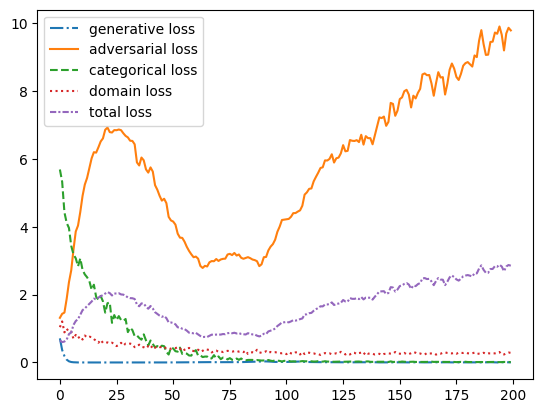

In [17]:
plot_loss_values(gl_, al_, cl_, dl_, tl_)

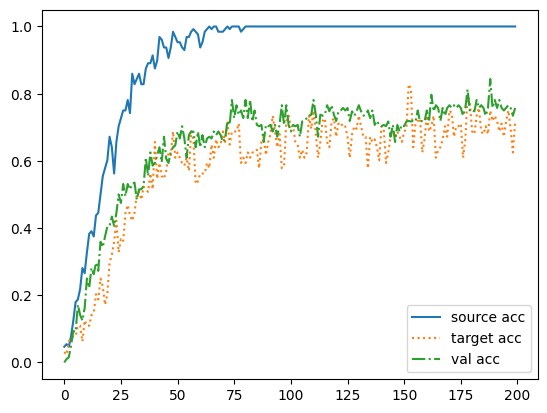

In [18]:
plot_acc_values(acc_source_, acc_target_, acc_source_val_)